# 最优投资组合

### MPT的假设
投资者是理性的并且风险厌恶

投资者追求收益最大化

所有投资者都想最大化期望收益

不考虑佣金和税费

所有投资者都可以接触到同样的信息源和与投资决策相关的全部必要信息

投资者可以以无风险利率不受限制的借入和贷出资金

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jqdatasdk as jq

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 导入数据

In [13]:
# JQData认证
jq.auth('********', '******')

# 设置起止时间及股票池
start_date = '2017-07-01'
end_date = '2019-07-01'
security_list = ['513100.XSHG', '518800.XSHG', '163407.XSHE', '000750.XSHE']

# 获取数据
stocks_price = jq.get_price(security_list, start_date=start_date, end_date=end_date, fields=['close'])['close']
stocks_price.head()

513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
2017-07-03        2.016        2.700        1.632         5.39
2017-07-04        1.992        2.682        1.612         5.33
2017-07-05        1.999        2.682        1.627         5.38
2017-07-06        2.012        2.686        1.629         5.36
2017-07-07        1.997        2.681        1.622         5.48

In [14]:
stocks_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2017-07-03 to 2019-07-01
Data columns (total 4 columns):
513100.XSHG    487 non-null float64
518800.XSHG    487 non-null float64
163407.XSHE    487 non-null float64
000750.XSHE    487 non-null float64
dtypes: float64(4)
memory usage: 19.0 KB


Text(0, 0.5, 'Price')

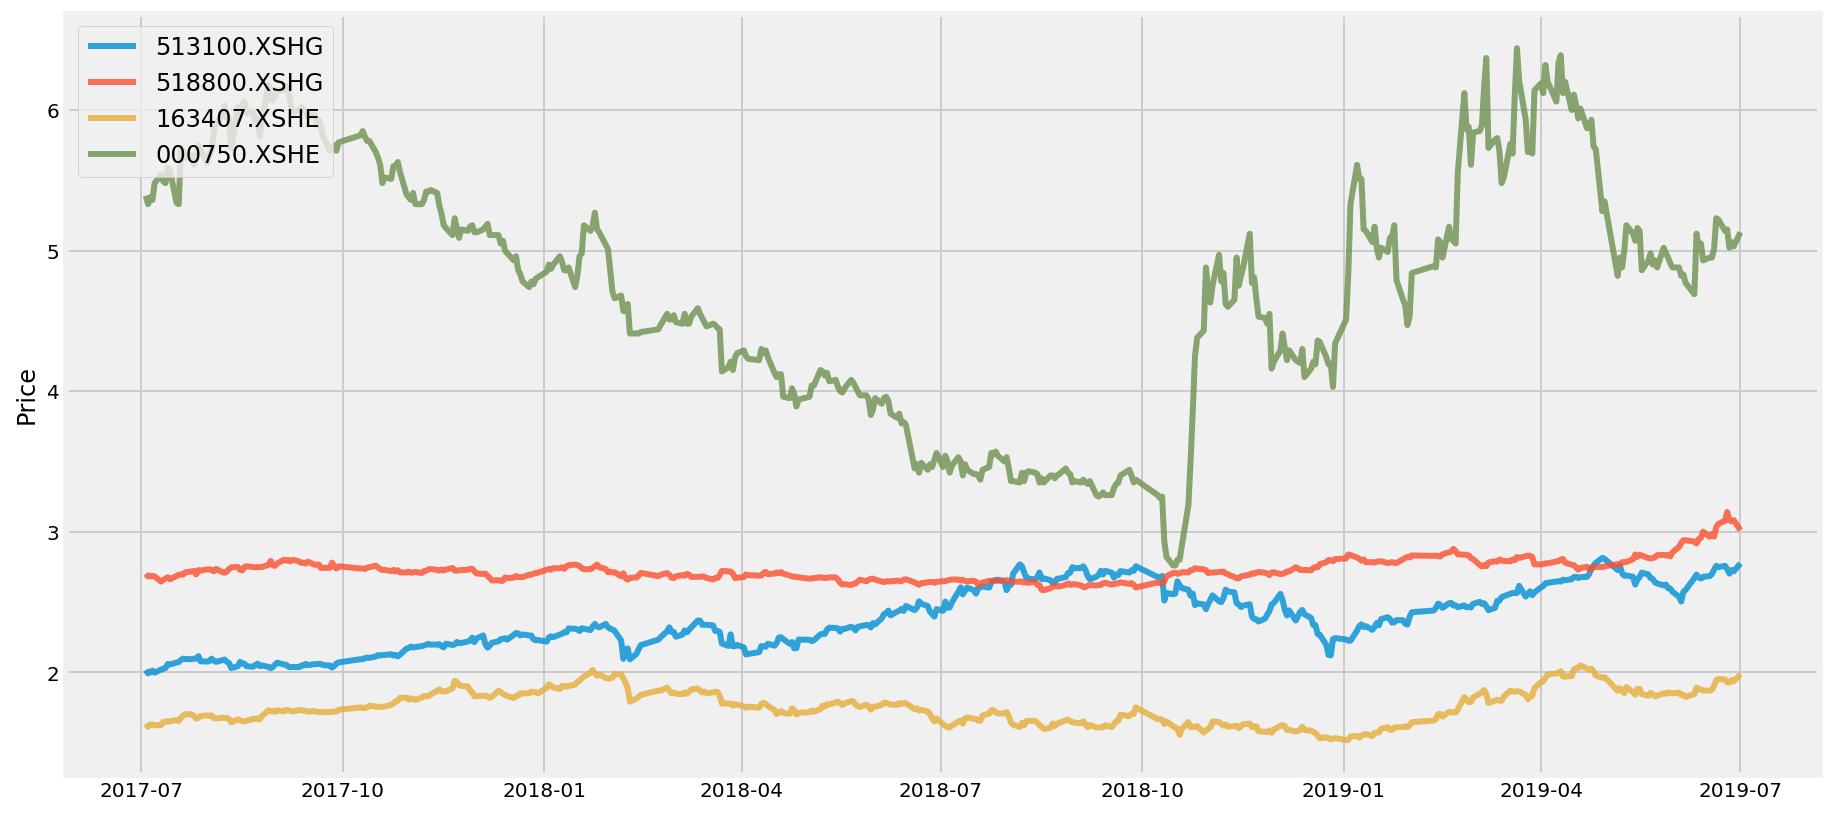

In [15]:
plt.figure(figsize=(14, 7))
for c in stocks_price.columns.values:
   plt.plot(stocks_price.index, stocks_price[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price')

Text(0, 0.5, 'daily returns')

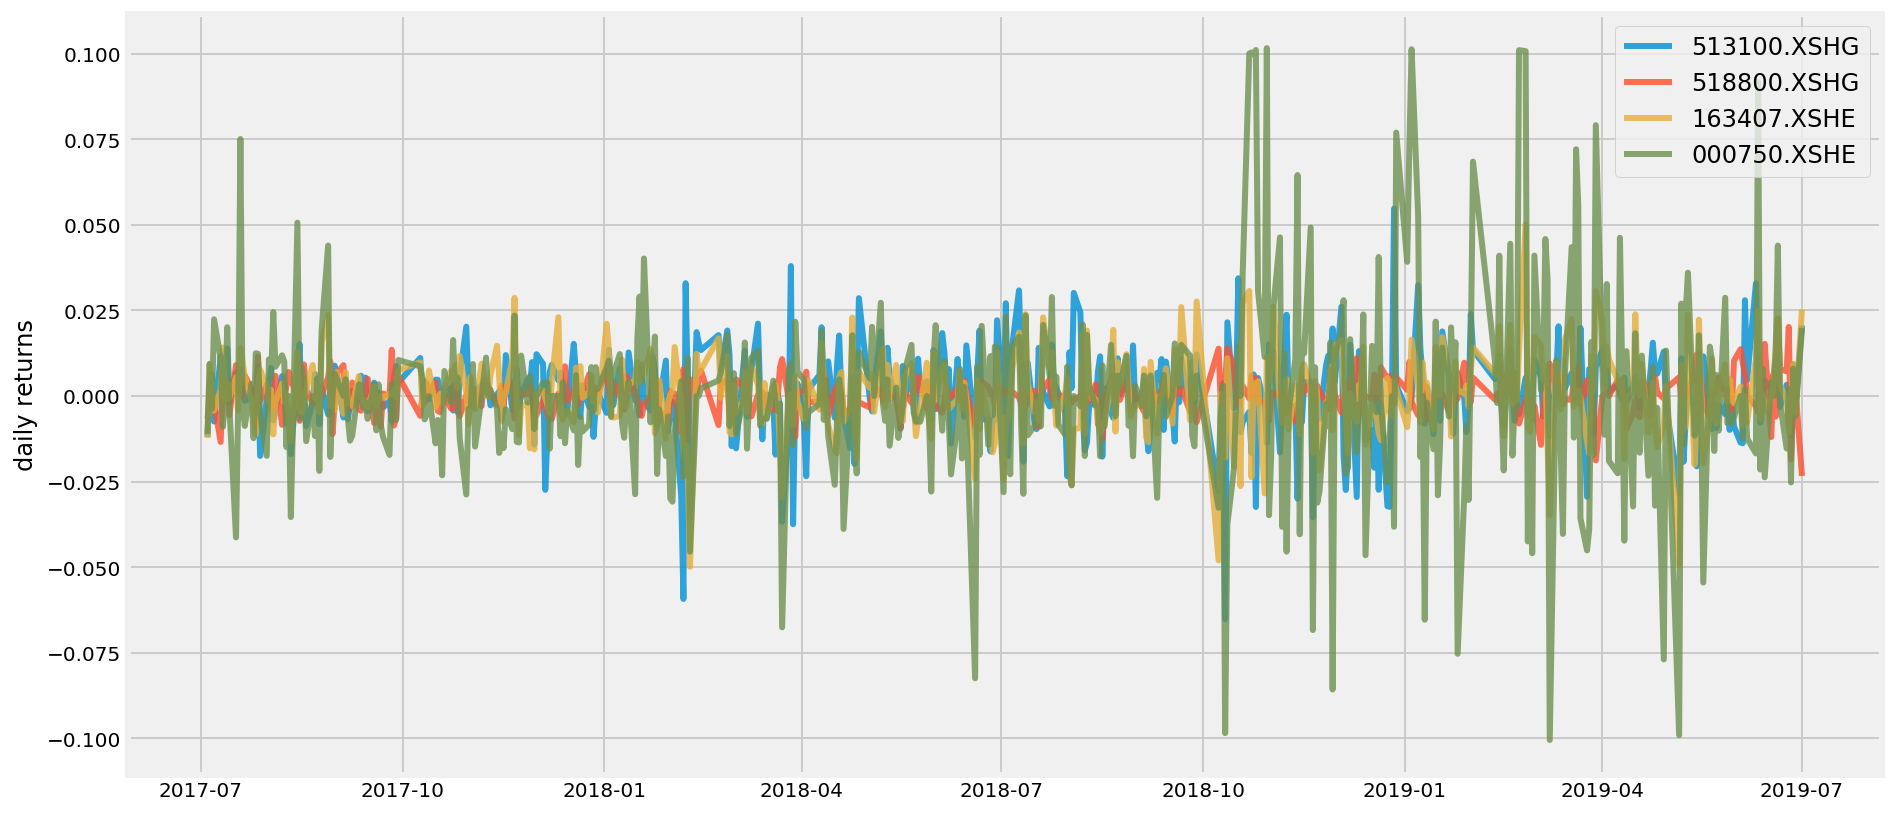

In [16]:
returns = stocks_price.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
   plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

## 构建投资组合
假设现在只有两个资产，投资的比重分别为w1，w2，投资组合的标准差可以表示为：

In [82]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/Yoga/Desktop/"
Image(filename = PATH + "640.jpg")

In [ ]:
用矩阵形式表示：

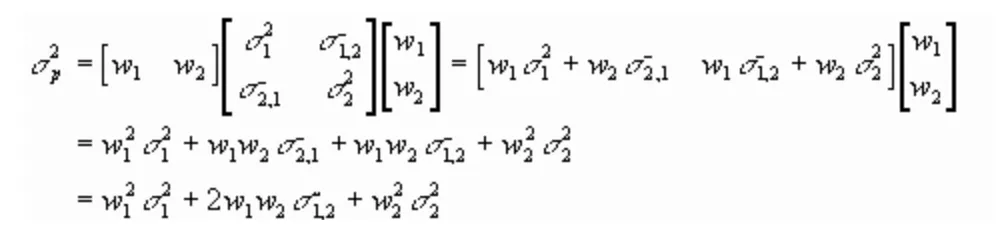

In [83]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/Yoga/Desktop/"
Image(filename = PATH + "641.jpg")

In [17]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
   returns = np.sum(mean_returns*weights ) *252  #一年252个交易日
   std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
   return std, returns

In [61]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
   results = np.zeros((3,num_portfolios))
   weights_record = []
   for i in range(num_portfolios):
       weights = np.random.random(4)
       weights /= np.sum(weights)
       weights_record.append(weights)
       portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
       results[0,i] = portfolio_std_dev
       results[1,i] = portfolio_return
       results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
   return results, weights_record

### 已知市场信息

In [62]:
returns = stocks_price.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178 #1.78%的无风险利率是在2018年初的52周的国库券利率。

### 最优投资组合可视化

In [65]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
   results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
   
   max_sharpe_idx = np.argmax(results[2])
   sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
   max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=stocks_price.columns,columns=['allocation'])
   max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
   max_sharpe_allocation = max_sharpe_allocation.T
   
   min_vol_idx = np.argmin(results[0])
   sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
   min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=stocks_price.columns,columns=['allocation'])
   min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
   min_vol_allocation = min_vol_allocation.T
   
   print ("-"*80)
   print ("Maximum Sharpe Ratio Portfolio Allocation\n")
   print ("Annualised Return:", round(rp,2))
   print ("Annualised Volatility:", round(sdp,2))
   print ("\n")
   print (max_sharpe_allocation)
   print ("-"*80)
   print ("Minimum Volatility Portfolio Allocation\n")
   print ("Annualised Return:", round(rp_min,2))
   print ("Annualised Volatility:", round(sdp_min,2))
   print ("\n")
   print (min_vol_allocation)
   
   plt.figure(figsize=(10, 7))
   plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
   plt.colorbar()
   plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
   plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
   plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
   plt.xlabel('annualised volatility')
   plt.ylabel('annualised returns')
   plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.07


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation        28.16        62.75         8.91         0.17
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.06


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation        13.72        72.71        12.17          1.4


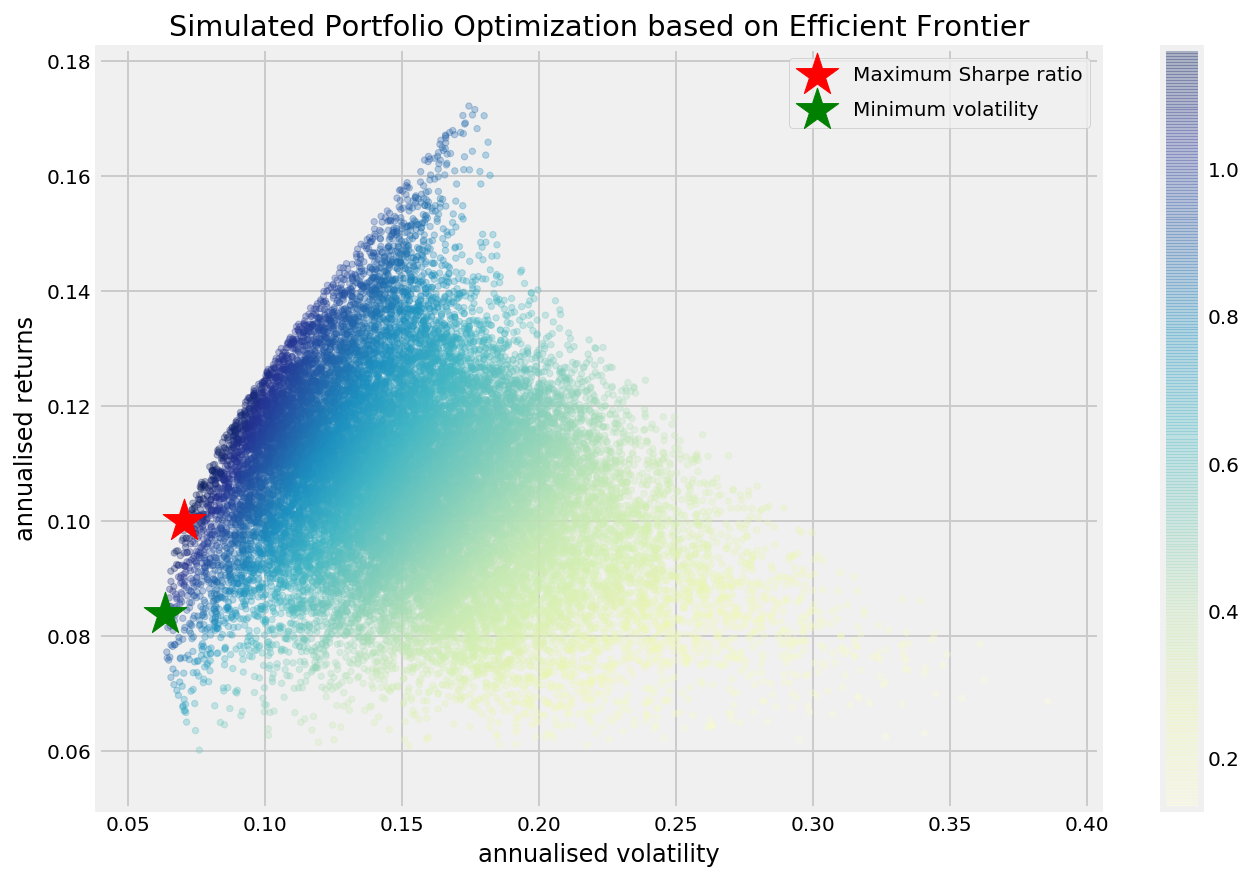

In [66]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

## 有效前沿
从随机生成的投资组合图中可以看出，蓝点聚集到一起在顶部形成了一条曲线。这条线就叫做有效前沿。

为什么称之为有效呢？因为对于给定的回报，在这条线上的点的风险最低，而在这条线右边的点的风险都会比线上的高。

如果期望收益率相同，当有一个风险较低的期权时，我们就没有必要去冒额外的风险了。

### 通过Scipy （凸优化）寻找有效前沿

In [93]:
import scipy.optimize as sco

#### 定义约束条件
1.权重之和为1,现有资金全部投入到投资组合中，不能再融资
2.权重w在0-1之间，不允许卖空

In [94]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#所有权重加总的和应该等于1。

#### 计算sharp ratio最小的组合 

In [95]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
   p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
   return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
   num_assets = len(mean_returns)
   args = (mean_returns, cov_matrix, risk_free_rate)
   constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
   bound = (0.0,1.0)
   bounds = tuple(bound for asset in range(num_assets))
   result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                       method='SLSQP', bounds=bounds, constraints=constraints)
   return result
#bound也是一个约束 取值在0-1之间，无法为股票分配负资产也不能分配超过100%的资产。

#### 计算volatility波动率最小的组合 

In [96]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
   return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
   num_assets = len(mean_returns)
   args = (mean_returns, cov_matrix)
   constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
   bound = (0.0,1.0)
   bounds = tuple(bound for asset in range(num_assets))

   result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                       method='SLSQP', bounds=bounds, constraints=constraints)

   return result

#### 计算给定回报的最有效投资组合

In [97]:
def efficient_return(mean_returns, cov_matrix, target):
   num_assets = len(mean_returns)
   args = (mean_returns, cov_matrix)

   def portfolio_return(weights):
       return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

   constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
   bounds = tuple((0,1) for asset in range(num_assets))
   result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
   return result

#### 计算一系列目标回报并计算每个回报对应的有效投资组合

In [98]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
   efficients = []
   for ret in returns_range:
       efficients.append(efficient_return(mean_returns, cov_matrix, ret))
   return efficients

### 绘制有效前沿

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.07


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation        27.96        59.57        12.47          0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.06


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation         12.8        74.27        12.82         0.11


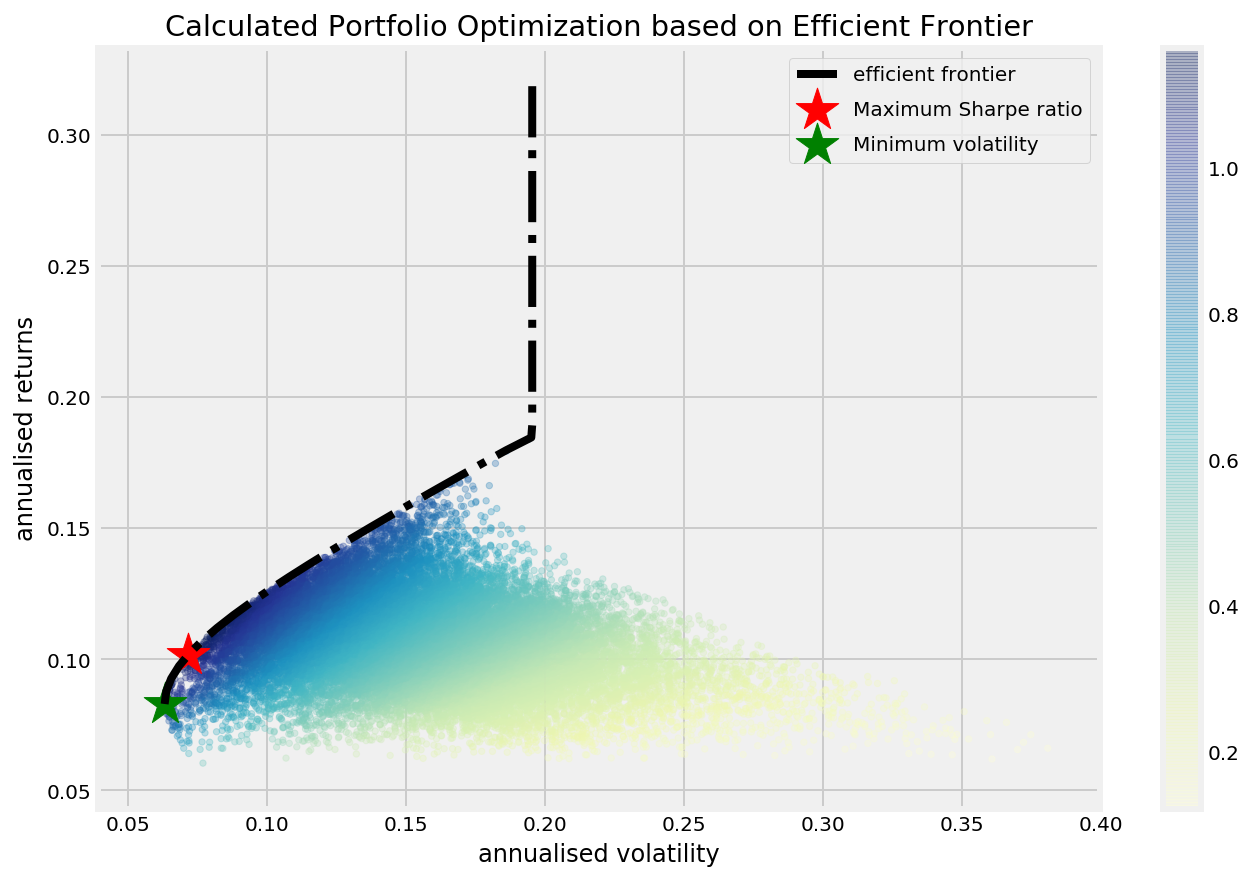

In [108]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
   results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
   
   max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
   sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
   max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=stocks_price.columns,columns=['allocation'])
   max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
   max_sharpe_allocation = max_sharpe_allocation.T
   max_sharpe_allocation

   min_vol = min_variance(mean_returns, cov_matrix)
   sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
   min_vol_allocation = pd.DataFrame(min_vol.x,index=stocks_price.columns,columns=['allocation'])
   min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
   min_vol_allocation = min_vol_allocation.T
   
   print ("-"*80)
   print ("Maximum Sharpe Ratio Portfolio Allocation\n")
   print ("Annualised Return:", round(rp,2))
   print ("Annualised Volatility:", round(sdp,2))
   print ("\n")
   print (max_sharpe_allocation)
   print ("-"*80)
   print ("Minimum Volatility Portfolio Allocation\n")
   print ("Annualised Return:", round(rp_min,2))
   print ("Annualised Volatility:", round(sdp_min,2))
   print ("\n")
   print (min_vol_allocation)
   

   plt.figure(figsize=(10, 7))
   plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
   plt.colorbar()
   plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
   plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

   target = np.linspace(rp_min, 0.32, 50)
   efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
   plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
   plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
   plt.xlabel('annualised volatility')
   plt.ylabel('annualised returns')
   plt.legend(labelspacing=0.8)

display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

#### 另一种可视化

In [112]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
   max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
   sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
   max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=stocks_price.columns,columns=['allocation'])
   max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
   max_sharpe_allocation = max_sharpe_allocation.T
   max_sharpe_allocation

   min_vol = min_variance(mean_returns, cov_matrix)
   sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
   min_vol_allocation = pd.DataFrame(min_vol.x,index=stocks_price.columns,columns=['allocation'])
   min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
   min_vol_allocation = min_vol_allocation.T
   
   an_vol = np.std(returns) * np.sqrt(252)
   an_rt = mean_returns * 252
   
   print ("-"*80)
   print ("Maximum Sharpe Ratio Portfolio Allocation\n")
   print ("Annualised Return:", round(rp,2))
   print ("Annualised Volatility:", round(sdp,2))
   print ("\n")
   print (max_sharpe_allocation)
   print ("-"*80)
   print ("Minimum Volatility Portfolio Allocation\n")
   print ("Annualised Return:", round(rp_min,2))
   print ("Annualised Volatility:", round(sdp_min,2))
   print ("\n")
   print (min_vol_allocation)
   print ("-"*80)
   print ("Individual Stock Returns and Volatility\n")
   for i, txt in enumerate(stocks_price.columns):
       print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
   print ("-"*80)
   
   fig, ax = plt.subplots(figsize=(10, 7))
   ax.scatter(an_vol,an_rt,marker='o',s=200)

   for i, txt in enumerate(stocks_price.columns):
       ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
   ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
   ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

   target = np.linspace(rp_min, 0.34, 50)
   efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
   ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
   ax.set_title('Portfolio Optimization with Individual Stocks')
   ax.set_xlabel('annualised volatility')
   ax.set_ylabel('annualised returns')
   ax.legend(labelspacing=0.8)

display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.07


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation        27.96        59.57        12.47          0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.06


            513100.XSHG  518800.XSHG  163407.XSHE  000750.XSHE
allocation         12.8        74.27        12.82         0.11
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

513100.XSHG : annuaised return 0.18 , annualised volatility: 0.2
518800.XSHG : annuaised return 0.06 , annualised volatility: 0.08
163407.XSHE : annuaised return 0.12 , annualised volatility: 0.18
000750.XSHE : annuaised return 0.06 , annualised volatility: 0.42
----------

## 补充：通过Monte Carlo模拟产生有效前沿组合

### Monte Carlo模拟50000个不同权重的投资组合产生的不同期望收益和期望波动率


In [113]:
returns_daily = stocks_price.pct_change()
returns_annual = returns_daily.mean() * 250

cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

num_assets = len(security_list)
num_portfolios = 50000

np.random.seed(101)

for single_portfolio in range(num_portfolios):
   weights = np.random.random(num_assets)
   weights /= np.sum(weights)
   returns = np.dot(weights, returns_annual)
   volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
   sharpe = returns / volatility
   sharpe_ratio.append(sharpe)
   port_returns.append(returns)
   port_volatility.append(volatility)
   stock_weights.append(weights)

portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(security_list):
   portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in security_list]
df = df[column_order]
df.head()

Returns  Volatility  Sharpe Ratio  513100.XSHG Weight  518800.XSHG Weight  \
0  0.110413    0.102386      1.078393            0.401223            0.443388   
1  0.097453    0.162055      0.601356            0.251963            0.306608   
2  0.126132    0.155026      0.813620            0.396923            0.104486   
3  0.095141    0.112808      0.843393            0.084002            0.362809   
4  0.090093    0.126439      0.712537            0.049376            0.356635   

   163407.XSHE Weight  000750.XSHE Weight  
0            0.022123            0.133266  
1            0.112865            0.328564  
2            0.304882            0.193709  
3            0.445883            0.107306  
4            0.430760            0.163229

### 可视化

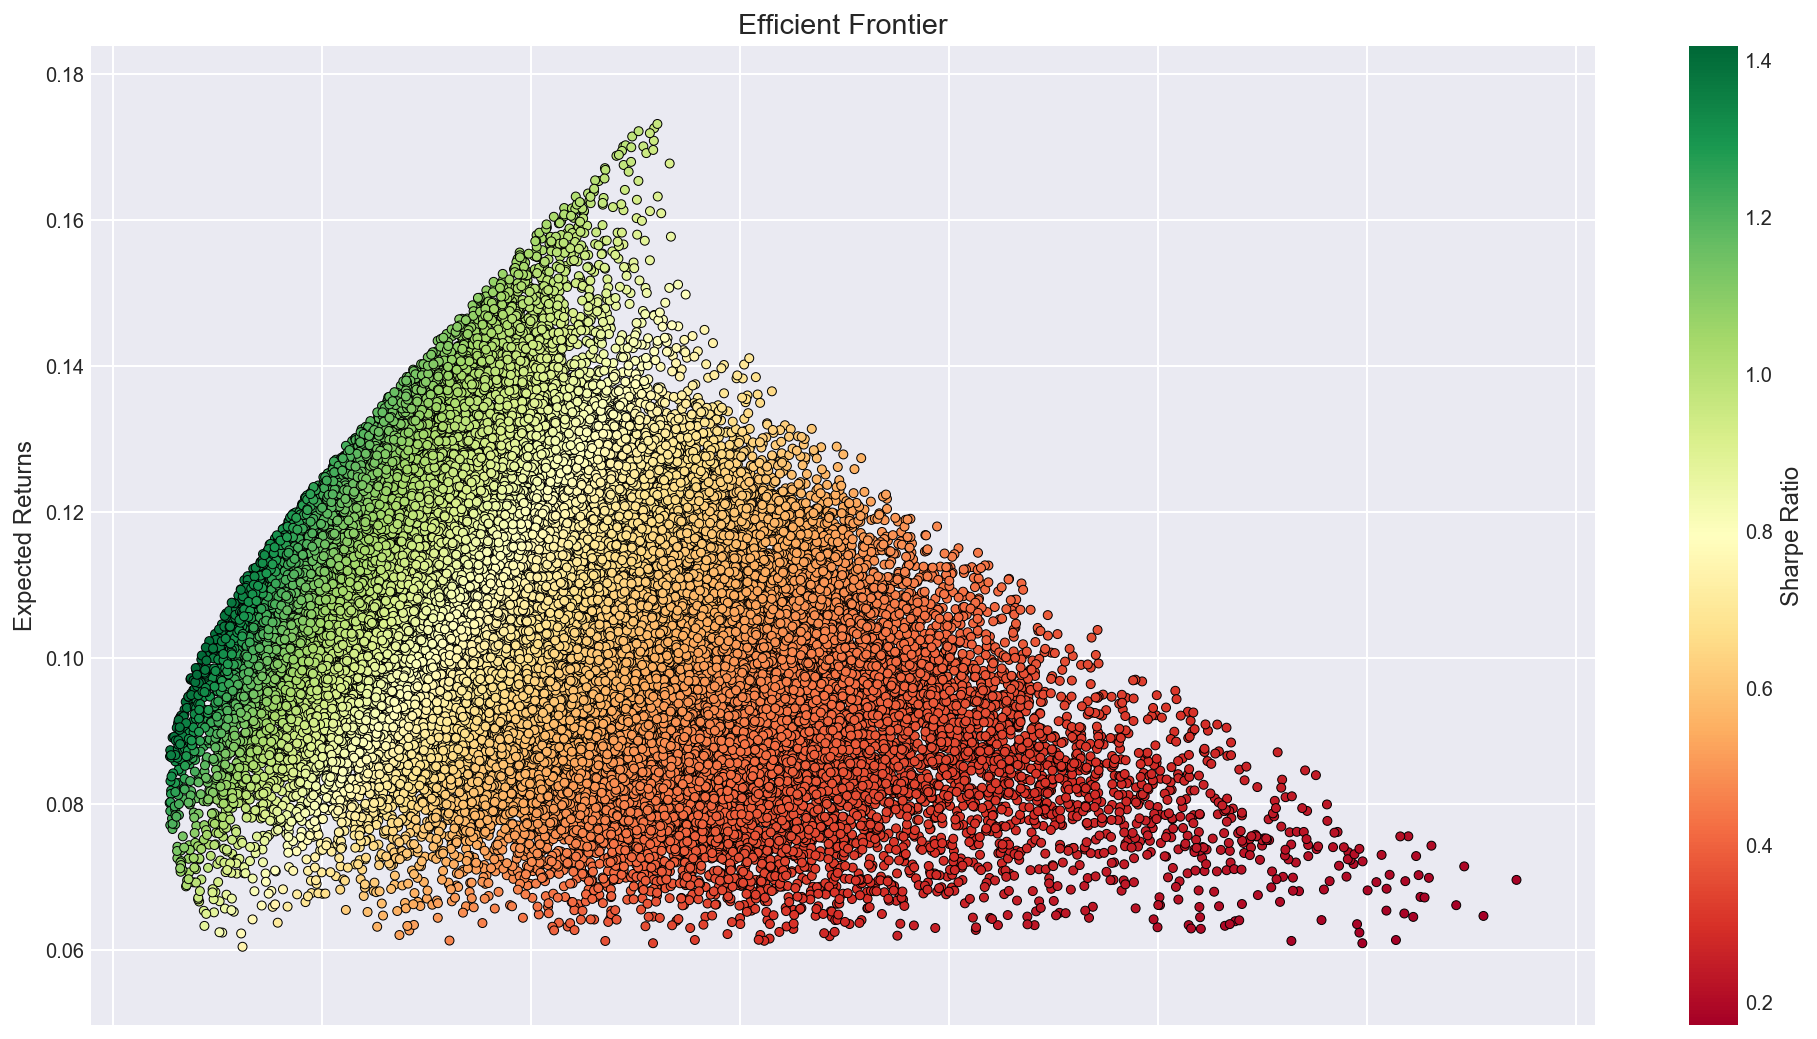

In [114]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
               cmap='RdYlGn', edgecolors='black', figsize=(15, 9), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

### 找出最优组合和有着最低波动率的组合

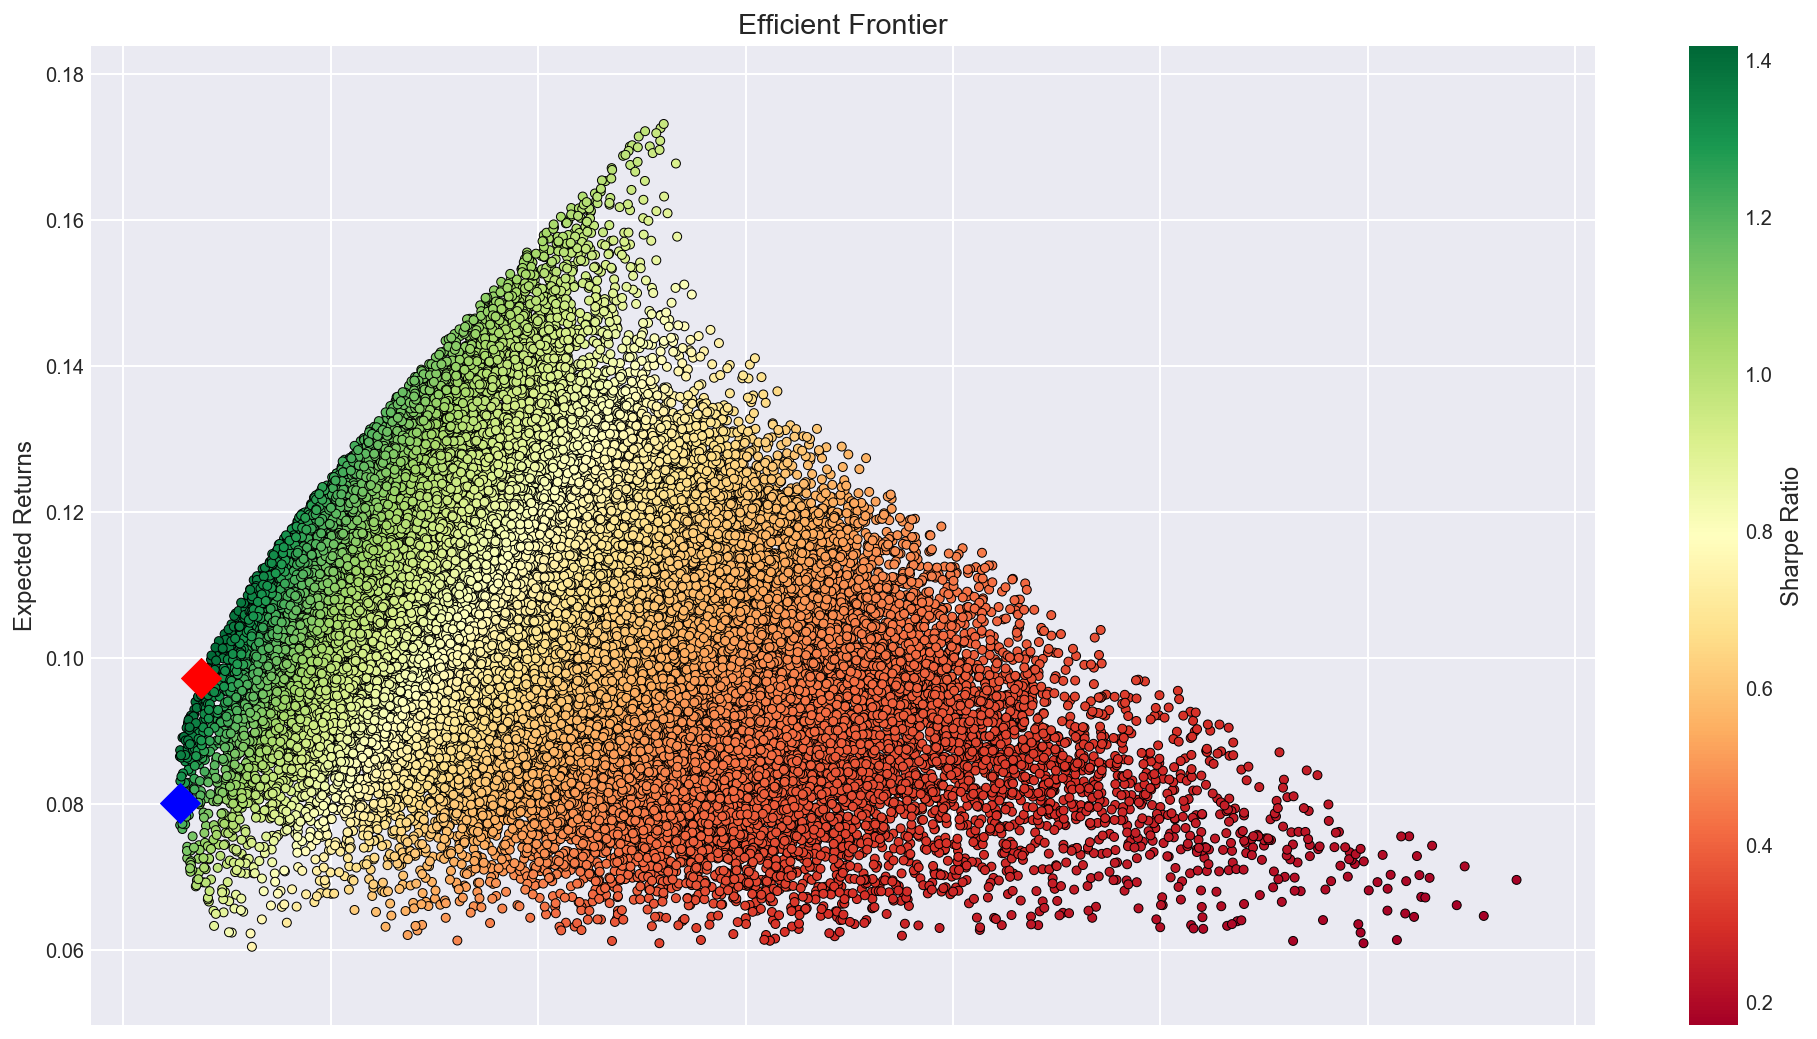

In [115]:
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
               cmap='RdYlGn', edgecolors='black', figsize=(15, 9), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [116]:
# 接下来输出这两个特殊组合的具体信息：
pd.concat([min_variance_port.T, sharpe_portfolio.T], axis=1)

21907     29131
Returns             0.080130  0.097211
Volatility          0.063524  0.068587
Sharpe Ratio        1.261408  1.417350
513100.XSHG Weight  0.092541  0.250354
518800.XSHG Weight  0.734995  0.623927
163407.XSHE Weight  0.167824  0.123824
000750.XSHE Weight  0.004641  0.001896

结果说明：

（1）风险厌恶最严重的投资者将会选择最小方差组合，它的期望收益率是8%，期望波动率是6.35%；

（2）追求最大风险调整收益率的投资者将会构建有着最大夏普比率的投资组合，它的期望收益率是9.72%，期望波动率是6.85%。